# Pulsebuilding for QCoDeS - Natalie Pearson Ed.

This set of tutorials covers the offline construction of pulse sequences from idea to numpy array to awg file. No instrument is required. In part one, we deal with individual pulse sequence elements. Part two covers sequences and awg files. 

## Lingo

Let's settle on a vocabulary. At the highest level, we construct **sequences**. These sequences will eventually be uploaded to an AWG, e.g. the Tektronix AWG 5014. Each sequence consists of several **elements** than again consist of a number of **channels**. On each channel reside a **waveform** and two **markers**. The waveform and markers may either be added as numpy arrays or as **blueprint**. A blueprint is a set of instructions for making a waveform and two markers and consists of several **segments**

That is to say, the food chain looks like: segment -> blueprint -> element -> sequence.


### Segments

#### Normal segments

A normal segment consists of a _unique_ name, a function object, a tuple of arguments to the function, an optional number of **timesteps**, and optionally a **duration** bound to it. 

 * The name: can be provided by the user or omitted. If omitted, the segment will get the name of its function. Since all names must be unique, the blueprint _appends numbers_ to names if they occur more than once. The numbers are appended chronologically throughout the blueprint. See example below. Note that valid input (base) names are strings NOT ending in a number. Thus, 'pi/2pulse' is valid, whereas 'pulsepi/2' is not.
 
 * The function: must be a python function taking at least two arguments; the sample rate and the segment duration. If the function takes other arguments (such as ramp slope, frequency, etc.) sample rate and duration arguments must be the last positional arguments. Keyword arguments are currently not allowed. See example at the very end.
 
 * The arguments: are in a tuple of $n-2$ arguments for a function taking $n$ arguments, i.e. specifying everything but the sample rate and duration.
 
 * The number of timesteps: can be 1 (default) or more. This is needed if a segment on one channel is to last while several different segments are run through on another channel of the same element. See example below.

* The durations may be a single value or a tuple of multiple values. The length of said tuple must match the number of timesteps bound to that segment

#### Special segments

A special segment has a (protected) name and a number of arguments. So far, two special segments are implemented.
 
 * `waituntil`, args [time (int)]:  When put in a blueprint, this function ensures that the _next_ segment starts at the absolute time `time` after the start of the element. It does so by filling any excess time with zeros. It fails if the previous segment will finish after time `time`.
 
 * `makemeanfit`. Not implemented yet.

### Blueprints

Consist of a number of segments. Can have an associated sample rate (required if durations are specified for the segments)

### Elements

Have an associated sample rate. 

### Sequences

Have an associated sample rate. 

In [1]:
%matplotlib nbagg
import qcodes.instrument_drivers.tektronix.pulsebuilding as pb
import numpy as np
import matplotlib.pyplot as plt

## Basic blueprinting

In [2]:
# The pulsebuilding module comes with a (small) collection of functions appropriate for being segments.
ramp = pb.PulseAtoms.ramp  # args: slope, offset
sine = pb.PulseAtoms.sine  # args: freq, ampl, off

# make a blueprint

# The blueprint takes no arguments
bp1 = pb.BluePrint()  # Do-nothing initialisation

# the blueprint is filled via the insertSegment method
# Call signature: position, function, args, name, timesteps, duration(s)
bp1.insertSegment(-1, ramp, (1, 0), name='', ts=1, durs=3)

bp1.setSR(100)

# The blueprint can be inspected
bp1.showPrint()

Legend: Name, function, arguments, timesteps, durations


Segment 1: "", PulseAtoms.ramp, (1, 0), 1, (3,)


In [3]:
bp1.len

AttributeError: 'BluePrint' object has no attribute 'len'

In [4]:
ramp.__name__

'ramp'

In [5]:
bp2 = bp1.copy()
bp2.changeDuration('ramp', 3)
bp2.setSR(100)

bp3 = pb.BluePrint()
bp3.insertSegment(-1, ramp, (0, 0), '', 1, 1)
bp3.insertSegment(-1, sine, (1, 1, 0), 'mysine', 1, 1)
bp3.insertSegment(-1, ramp, (0, 0), '', 1, 1)

bp3.setSR(100)
print(bp2.length_seconds, bp2.length_numpoints, bp1.length_seconds, bp1.length_numpoints)

3.0 300 3.0 300


In [6]:
bp2._tslist

[1]

## Elements

In [7]:
elem1 = pb.Element()

elem1.addBluePrint(1, bp1)
elem1.addBluePrint(2, bp2)
elem1.addBluePrint(3, bp3)
elem1.validateDurations()

print(elem1.SR, elem1.duration)

100 3.0


In [8]:
help(elem1.validateDurations)

Help on method validateDurations in module qcodes.instrument_drivers.tektronix.pulsebuilding:

validateDurations() method of qcodes.instrument_drivers.tektronix.pulsebuilding.Element instance
    Check that all channels have the same specified duration, number of
    points and sample rate.



In [9]:
help(bp1.changeArg)

Help on method changeArg in module qcodes.instrument_drivers.tektronix.pulsebuilding:

changeArg(name, arg, value, replaceeverywhere=False) method of qcodes.instrument_drivers.tektronix.pulsebuilding.BluePrint instance
    Change an argument of one or more of the functions in the blueprint.
    
    Args:
        name (str): The name of the segment in which to change an argument
        arg (Union[int, str]): Either the position (int) or name (str) of
            the argument to change
        value (Union[int, float]): The new value of the argument
        replaceeverywhere (bool): If True, the same argument is overwritten
            in ALL segments where the name matches. E.g. 'gaussian1' will
            match 'gaussian', 'gaussian2', etc. If False, only the segment
            with exact name match gets a replacement.
    
    Raises:
        ValueError: If the argument can not be matched (either the argument
            name does not match or the argument number is wrong).



In [11]:
checkseq = pb.makeLinearlyVaryingSequence(elem1, 3, 'mysine', 'freq', 1, 8, 1)

In [ ]:
checkseq = pb.makeLinearlyVaryingSequence(elem1, 3, 'mysine', 'freq', 1, 8, 1)

In [ ]:
elem1._data[3]['blueprint']._argslist

<IPython.core.display.Javascript object>


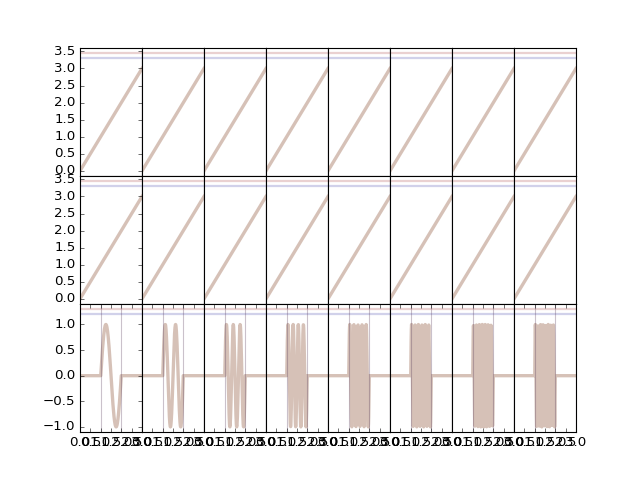

In [12]:
checkseq.plotSequence()

In [ ]:
bp_pulse = pb.BluePrint()
bp_pulse.insertSegment(-1, ramp, (0, 0), 'deadtime', 1, 1)
bp_pulse.insertSegment(-1, ramp, (0, 1), 'onstate', 1, 1)
bp_pulse.insertSegment(-1, 'waituntil', 10, '', 1, None)
bp_pulse.setSR(250)

elem2 = pb.Element()
elem2.addBluePrint(1, bp_pulse)

tseq = pb.makeLinearlyVaryingSequence(elem2, 1, 'onstate', 'duration', 1, 5, 1)


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
testelem = elem2.copy()
arrs1 = testelem.getArrays()
testelem.changeDuration(1, 'onstate', 2)
arrs2 = testelem.getArrays()

myseq = pb.Sequence2()
myseq.setSR(250)
myseq.addElement(1, elem2)
myseq.addElement(2, testelem)
myseq.plotSequence()

In [ ]:
tseq.plotSequence()

## Multi-variation

<IPython.core.display.Javascript object>


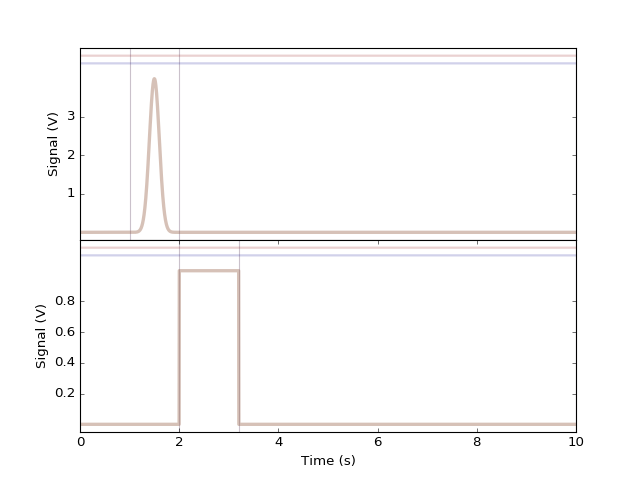

In [13]:
# A gaussian and a box
gauss = pb.PulseAtoms.gaussian

t1 = 1
t2 = 1  # to be changed later
t3 = 1.2
total_time = 10

bp_gauss = pb.BluePrint()
bp_gauss.setSR(500)
bp_gauss.insertSegment(0, ramp, (0, 0), durs=t1)
bp_gauss.insertSegment(1, gauss, (1, 0.1, 0, 0), durs=t2, name='mygauss')
bp_gauss.insertSegment(2, 'waituntil', (total_time,), durs=None)

bp_box = pb.BluePrint()
bp_box.setSR(500)
bp_box.insertSegment(0, ramp, (0, 0), ts=2, durs=(t1, t2), name='waitstate')
bp_box.insertSegment(1, ramp, (0, 1), durs=t3)
bp_box.insertSegment(2, 'waituntil', (total_time,), durs=None)

# Element
mvelem = pb.Element()
mvelem.addBluePrint(1, bp_gauss)
mvelem.addBluePrint(2, bp_box)
mvelem.validateDurations()
mvelem.plotElement()

<IPython.core.display.Javascript object>


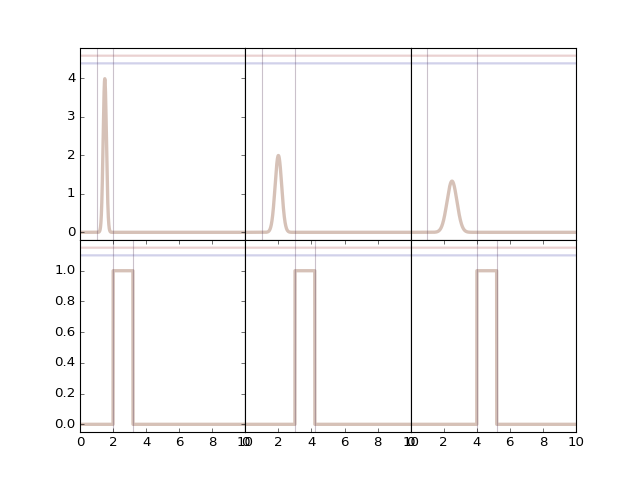

In [14]:
# Now make a sequence broadening the Gaussian
sigmas = [0.1, 0.2, 0.3]
gdurs = [1, 2, 3]
wdurs = [(1, 1), (1, 2), (1, 3)]
channels = [1, 1, 2]
names = ['mygauss', 'mygauss', 'waitstate']
args = ['sigma', 'duration', 'duration']

mvseq = pb.makeVaryingSequence(mvelem, channels, names, args, [sigmas, gdurs, wdurs])

mvseq.plotSequence()

In [ ]:
mvelem.SR

In [ ]:
print('{}\n{}\n{}\n\n\n'.format(bp_gauss._funlist, bp_gauss._argslist, bp_gauss._durslist))
print('{}\n{}\n{}\n\n\n'.format(bp_box._funlist, bp_box._argslist, bp_box._durslist))

## Sequence

In [ ]:
seq = pb.Sequence2()

seq.addElement(1, elem1)
seq.setSR(elem1.SR)
seq.checkConsistency()
seq.setSequenceSettings(1, 1, 1, 1, 1)
seq.setChannelVoltageRange(1, 10, 0)
seq.setChannelVoltageRange(2, 10, 0)
seq.setChannelVoltageRange(3, 10, 0)
help(seq.setChannelVoltageRange)

In [ ]:
seq._data

In [ ]:
tuptup = seq.outputForAWGFile()

In [ ]:
# Alternatively, one construct a blueprint by adding segments one-by-one
bp2 = pb.BluePrint([], [], [])
bp2.insertSegment(-1, ramp, (-1, 0))
bp2.insertSegment(-1, sine, (5, 1, 1), 'wiggle', 2)
bp2.insertSegment(-1, ramp, (2, 0))

# This achieves the same as the code above, as we may conclude by inspection...
bp2.showPrint()
# ... or by direct comparison
print('---')
print(bp1==bp2)

In [ ]:
bp1.length_timesteps

In [ ]:
help(pb.bluePrintPlotter)

In [ ]:
bp1 = pb.BluePrint([ramp, sine, ramp],  # functions
                   [(-1, 0), (5, 1, 1), (2, 0)],  # arguments
                   ['', 'wiggle', ''],  # names
                   [1, 2, 1],
                   durations = [4, 4, 4, 4])  # (optional) timesteps

In [ ]:
bp1._durslist

In [ ]:
# It is also possible to copy blueprints
bp3 = bp1.copy()
print('Are bp1 and bp3 identical?', bp3==bp1)

# Let's say we now want to modify bp3 to have no sine function but only ramps
bp3.removeSegment('wiggle')  # remove the offending segment
bp3.insertSegment(1, ramp, (1, 0))  # insert a ramp before element 1 (the second element)
bp3.insertSegment(2, ramp, (0, 0))  # insert a ramp

# And let's say that we want to change the frequency of the sine of bp2
# we can adress the argument by its position...
bp2.changeArg('wiggle', 0, 2.5)
# ...or by its name (even though it's NOT a keyword argument)
bp2.changeArg('wiggle', 'freq', 2.5)

# Of course, the blueprints differ now
print('Are bp2 and bp3 still identical?', bp3==bp1)

In [ ]:
# It can be useful to add two blueprints together
bp4 = pb.BluePrint([ramp], [(1, 0)], [''])
bp5 = bp4.copy()
for ii in range(3):
    bp4.showPrint()
    print('--')
    bp4 += bp5

In [ ]:
# And of course, at some point we would like to add markers
# The markers are zero by default.
# The marker is specified as a list of tuples. The first number is the absolute time at which to turn on,
# the second is the duration until the marker turns off again
bp2.marker1 = [(1, 0.1), (2, 1)]
bp2.marker2 = [(1.1, 0.9), (3, 1)]

## Forging and plotting

In [ ]:
# Finally, we may provide a sample rate and durations and plot and forge the segments
durations = [1, 2, 0.5, 1]
SR = 100

# plot, see that everything we did above makes sense
pb.bluePrintPlotter([bp1, bp2, bp3, bp4], 100, durations)

# The two lines above the waveform represent marker1 (red) and marker2 (blue), respectively

In [ ]:
# Forging is very similar to plotting
element = pb.elementBuilder(bp2, SR, durations)

# the elementBuilder returns the element as a dictionary. The docstring explains everything
help(pb.elementBuilder)

multichannelelement = pb.elementBuilder([bp1, bp2], SR, durations, channels=[1, 3])
plt.figure(figsize=(8, 2))
plt.plot(multichannelelement[3][1], lw=2, color=(0.6, 0.1, 0.1), alpha=0.5)
plt.plot(multichannelelement[3][2], lw=2, color=(0.1, 0.1, 0.6), alpha=0.5)
plt.ylim([-0.1, 1.1])

## More advanced examples

### Multiple argument replacement

In [ ]:
gaussian = pb.PulseAtoms.gaussian

# we make a blueprint with some gaussians
gbp = pb.BluePrint([gaussian, ramp, gaussian, sine, gaussian],
                   [(1, 0.2, 0, 0), (-0.5, 0.5), (1, 0.5, 0, 0), (5, 1, 0), (1, 0.4, 0, 0)],
                   ['', '', '', '', ''])

# and realise that all sigmas where way too large...
# Make the gaussians thinner and smaller
gbp2 = gbp.copy()
gbp2.changeArg('gaussian', 'sigma', 0.05, replaceeverywhere=True)
gbp2.changeArg('gaussian', 'ampl', 0.25, replaceeverywhere=True)
pb.bluePrintPlotter([gbp, gbp2], SR, [1, 1, 1, 1, 1])

In [ ]:
# The 'replaceeverywhere' looks for similar names, so naming can be used to discriminate 

# we make a blueprint with some gaussians
gbp = pb.BluePrint([gaussian, ramp, gaussian, sine, gaussian],
                   [(1, 0.2, 0, 0), (0, 0.25), (1, 0.5, 0, 0), (5, 1, 0), (1, 0.4, 0, 0)],
                   ['badgauss', '', 'goodgauss', '', 'goodgauss'])

# and realise that all sigmas where way too large...
# Make the gaussians thinner and smaller
gbp2 = gbp.copy()
gbp2.changeArg('goodgauss', 'sigma', 0.05, replaceeverywhere=True)
gbp2.changeArg('goodgauss', 'ampl', 0.25, replaceeverywhere=True)
pb.bluePrintPlotter([gbp, gbp2], SR, [1, 1, 1, 1, 1])

### Using the 'waituntil' special function

In [ ]:
# The 'waituntil' function is utilised by adding the string 'waituntil' as a function. The corresponding argument
# is the ABSOLUTE time at which the NEXT segment should begin

bpwait = pb.BluePrint([ramp, sine, 'waituntil', sine],
                      [(0.1, -0.05), (1, 1, 0.5), (5.5,), (2, 1, -0.5)],
                      ['', '', '', ''])

# When plotting/forging, no duration should be specified for the 'waituntil' segment
pb.bluePrintPlotter(bpwait, SR, [1, 1, None, 1.5])


In [ ]:
bpwait.getLength(SR, [1, 1, None, 1.5])

### Binding markers to specific segments

In [ ]:
# It might be useful to have a marker indicating that some segment has been (or will soon be) reached

bp = pb.BluePrint([], [], [])
bp.insertSegment(0, ramp, (0, 0))
bp.insertSegment(1, ramp, (0.2, 0))
bp.insertSegment(2, sine, (5, 1, 0))  # This is the important segment
# make marker 1 go ON a bit before the sine comes on
bp.setSegmentMarker('sine', (-0.1, 0.2), 1)  # segment name, (delay, duration), markerID
# make marker 2 go ON halfway through the sine
bp.setSegmentMarker('sine', (0.75, 0.1), 2)

durations = [1, 1.2, 1.5]
pb.bluePrintPlotter(bp, SR, durations)

# Now we realise that we forgot to insert some segments...
bp.insertSegment(0, gaussian, (0.25, 0.04, 0.1, 0))
bp.insertSegment(-1, ramp, (-0.2, 0))
# and that we want a marker at 2s
bp.marker1 = [(2, 0.1)]

# The markers for the sine are still correctly bound:
pb.bluePrintPlotter(bp, SR, [1] + durations + [0.7])

# NB: the two different ways of inputting markers will never directly conflict, since one only specifies when to turn 
# markers ON. It is up to the user to ensure that markers switch off again as expected, i.e. that different marker
# specifications do not overlap.

In [ ]:
# The bound marker can be removed again
bp.removeSegmentMarker('sine', 1)
pb.bluePrintPlotter(bp, SR, [1] + durations + [0.7])

### Adding arbitrary segments

Custom-made python function can be added to a blueprint. The requirements are the following:
  
  * The function must take N+2 aedrguments, where N=0,1,2,... and where the last two arguments are SR and durations
  * Keyword arguments are not allowd
  * The function must return a list or an np.array with the functional values
  
Below an example

In [ ]:
def noisy_sine(ampl, freq, SR, dur):
    N = int(np.round(SR*dur))
    time = np.linspace(0, dur, N)
    noise = np.random.randn(N)
    return list(ampl*np.sin(2*np.pi*freq*time)+noise)

def harmonics(basefreq, n, SR, dur):
    N = int(np.round(SR*dur))
    time = np.linspace(0, dur, N)
    output = np.sin(basefreq*2*np.pi*time)
    for ii in range(n):
        output += np.sin(ii*basefreq*2*np.pi*time)
    return output

custombp = pb.BluePrint([ramp, noisy_sine, ramp, harmonics],
                        [(0, 0), (1, 5), (0, 0), (2.5, 5)],
                        ['', '', '', ''])

pb.bluePrintPlotter(custombp, 200, [1, 1, 1, 1])